In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
 
# !pip install lightgbm xgboost
import lightgbm as lgbm
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [4]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data', names = ['age', 'years operate', 'pos axillary nodes', 'survival state'])

In [5]:
print(data.info())
print('\n')
print(data.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 306 non-null    int64
 1   years operate       306 non-null    int64
 2   pos axillary nodes  306 non-null    int64
 3   survival state      306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB
None


                    count       mean        std   min   25%   50%    75%   max
age                 306.0  52.457516  10.803452  30.0  44.0  52.0  60.75  83.0
years operate       306.0  62.852941   3.249405  58.0  60.0  63.0  65.75  69.0
pos axillary nodes  306.0   4.026144   7.189654   0.0   0.0   1.0   4.00  52.0
survival state      306.0   1.264706   0.441899   1.0   1.0   1.0   2.00   2.0


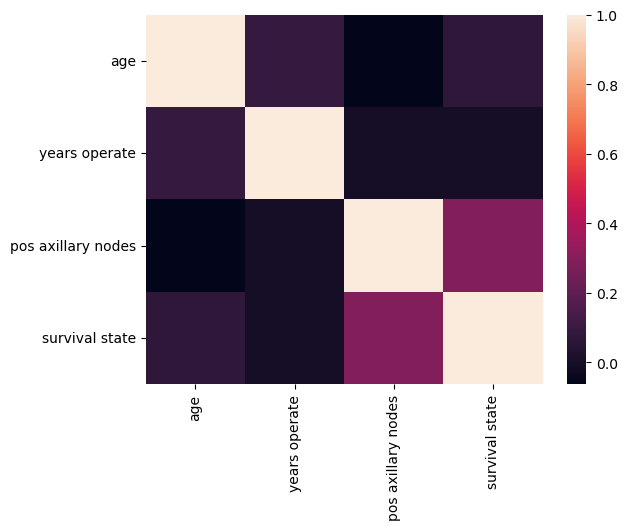

In [6]:
corr = data.corr() 
sns.heatmap(corr)
plt.show()

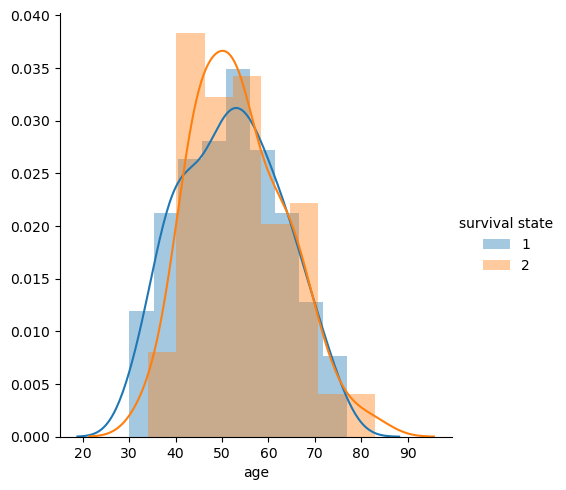

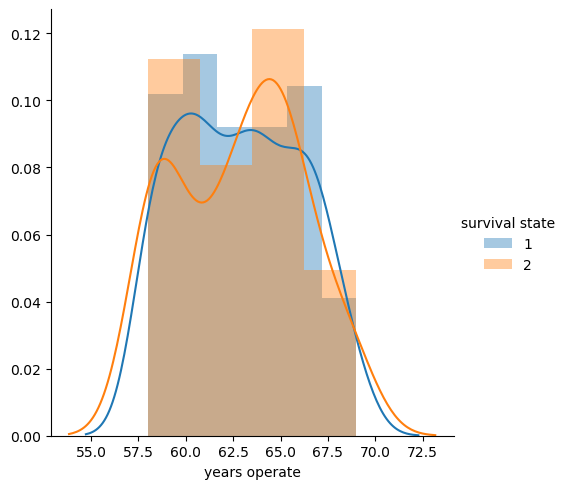

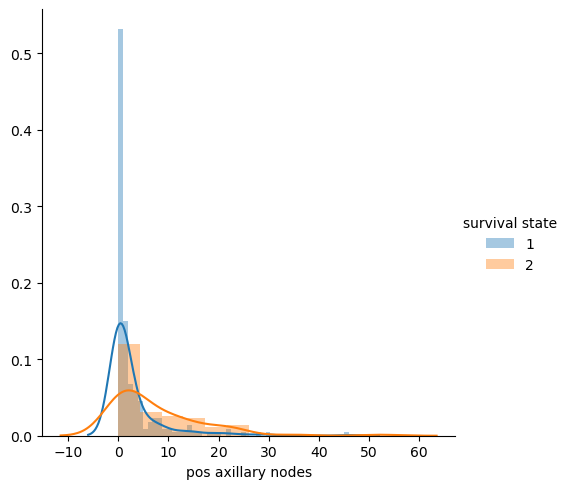

In [7]:
for col in data.columns[:-1]:
    sns.FacetGrid(data, hue = 'survival state', size = 5).map(sns.distplot, col).add_legend() 
    plt.ylabel(None)
    plt.show()

PDF: [0.05228758 0.08823529 0.1503268  0.17320261 0.17973856 0.13398693
 0.13398693 0.05882353 0.02287582 0.00653595]
CDF: [0.05228758 0.14052288 0.29084967 0.46405229 0.64379085 0.77777778
 0.91176471 0.97058824 0.99346405 1.        ]


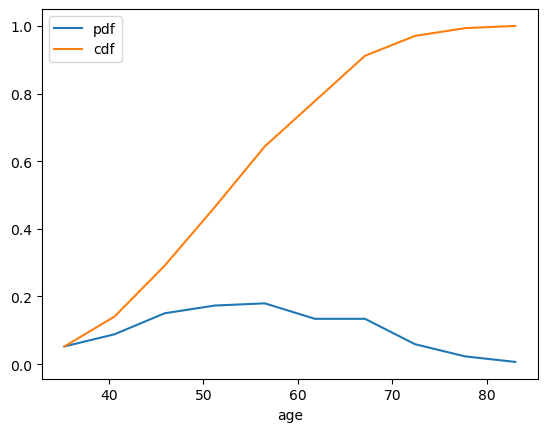

PDF: [0.20588235 0.09150327 0.08496732 0.0751634  0.09803922 0.10130719
 0.09150327 0.09150327 0.08169935 0.07843137]
CDF: [0.20588235 0.29738562 0.38235294 0.45751634 0.55555556 0.65686275
 0.74836601 0.83986928 0.92156863 1.        ]


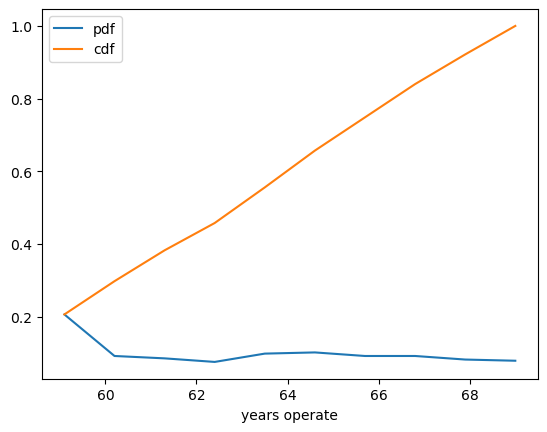

PDF: [0.77124183 0.09803922 0.05882353 0.02614379 0.02941176 0.00653595
 0.00326797 0.         0.00326797 0.00326797]
CDF: [0.77124183 0.86928105 0.92810458 0.95424837 0.98366013 0.99019608
 0.99346405 0.99346405 0.99673203 1.        ]


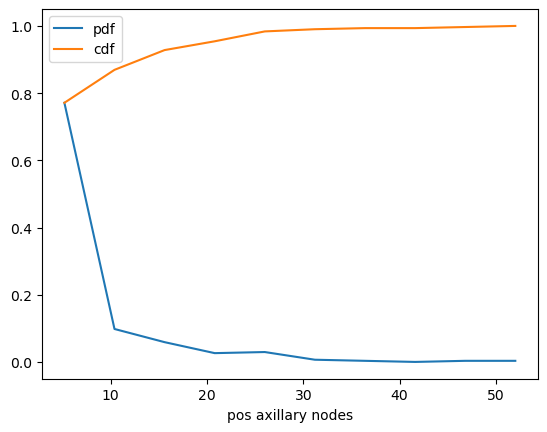

In [8]:
# pdf and cdf
for col in data.columns[:-1]:
    count, bins_count = np.histogram(data[col], bins=10)
    pdf = count / sum(count)
    print("PDF: {}".format(pdf))
    cdf = np.cumsum(pdf)
    print('CDF: {}'.format(cdf))
    
    plt.plot(bins_count[1:], pdf, label = 'pdf')
    plt.plot(bins_count[1:], cdf, label = 'cdf')
    plt.xlabel(col)
    plt.legend(loc = 'upper left')
    plt.show()

In [9]:
bins_count

array([ 0. ,  5.2, 10.4, 15.6, 20.8, 26. , 31.2, 36.4, 41.6, 46.8, 52. ])

In [17]:
# base model
scaler = StandardScaler()
scaler.fit(data)
scaler.transform(data)

y = data['survival state']
x = data.drop(['survival state'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

lr = LogisticRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

rep = classification_report(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(rep)
print('Accuracy: {}'.format(acc)) 

              precision    recall  f1-score   support

           1       0.63      0.98      0.77        58
           2       0.50      0.03      0.06        34

    accuracy                           0.63        92
   macro avg       0.57      0.51      0.41        92
weighted avg       0.58      0.63      0.51        92

Accuracy: 0.6304347826086957


In [18]:
# optimal hyperparameter
params = {
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'random_state': np.arange(0, 50, 1),
    'C': np.arange(0.5, 1.5, 0.1),
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

model = GridSearchCV(lr, param_grid = params, n_jobs = -1, verbose = 1)
model.fit(x_train, y_train)
print(model.best_params_)

y_pred = model.predict(x_test)

rep = classification_report(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(rep)
print('Accuracy: {}'.format(acc)) 

Fitting 5 folds for each of 9000 candidates, totalling 45000 fits
{'C': 0.5, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           1       0.64      0.98      0.78        58
           2       0.67      0.06      0.11        34

    accuracy                           0.64        92
   macro avg       0.65      0.52      0.44        92
weighted avg       0.65      0.64      0.53        92

Accuracy: 0.6413043478260869


In [19]:
# ensemble model
def ensemble_model(x):
    regr = TransformedTargetRegressor(regressor = x, transformer = QuantileTransformer(output_distribution = 'normal'))
    regr.fit(x_train, y_train)
    yhat = regr.predict(x_test)
    return [classification_report(yhat, y_test), accuracy_score(yhat, y_test)]

algo = [GradientBoostingRegressor(), lgbm.LGBMRegressor(), xg.XGBRFRegressor()]

result = []
for a in algo:
    result.append(ensemble_model(a))

for i, a in enumerate(algo):
    print(a.__class__.__name__)
    rep, acc = result[i]
    
    print(rep)
    print('Accuracy: {}'.format(acc))
    

GradientBoostingRegressor
              precision    recall  f1-score   support

         1.0       0.90      0.65      0.75        80
         2.0       0.18      0.50      0.26        12

    accuracy                           0.63        92
   macro avg       0.54      0.57      0.51        92
weighted avg       0.80      0.63      0.69        92

Accuracy: 0.6304347826086957
LGBMRegressor
              precision    recall  f1-score   support

         1.0       0.93      0.65      0.77        83
         2.0       0.15      0.56      0.23         9

    accuracy                           0.64        92
   macro avg       0.54      0.60      0.50        92
weighted avg       0.85      0.64      0.71        92

Accuracy: 0.6413043478260869
XGBRFRegressor
              precision    recall  f1-score   support

         1.0       0.93      0.66      0.77        82
         2.0       0.18      0.60      0.27        10

    accuracy                           0.65        92
   macro avg   